In [ ]:
import math, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union
from sklearn.preprocessing import StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
)
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
)
from sklearn.linear_model import (
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    HuberRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from collections import Counter

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.width", 500)

In [ ]:
df = pd.read_csv('data/medical_insurance.csv')
df

,age,gender,bmi,children,discount_eligibility,region,expenses,premium
0,19,female,27.90,0,yes,southwest,16884.92,168.85
1,18,male,33.80,1,no,southeast,1725.55,17.26
2,28,male,33.00,3,no,southeast,4449.46,44.49
3,33,male,22.70,0,no,northwest,21984.47,439.69
4,32,male,28.90,0,no,northwest,3866.86,77.34
...,...,...,...,...,...,...,...,...
1333,50,male,31.00,3,no,northwest,10600.55,212.01
1334,18,female,31.90,0,no,northeast,2205.98,22.06
1335,18,female,36.90,0,no,southeast,1629.83,16.30
1336,21,female,25.80,0,no,southwest,2007.95,20.08


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1338 non-null   int64  
 1   gender                1338 non-null   object 
 2   bmi                   1338 non-null   float64
 3   children              1338 non-null   int64  
 4   discount_eligibility  1338 non-null   object 
 5   region                1338 non-null   object 
 6   expenses              1338 non-null   float64
 7   premium               1338 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 83.8+ KB


In [ ]:
def grab_col_names(df, categorical_threshold=10, cardinal_threshold=20):
    """
    Numerical_cols, categorical_cols, cardinal_cols, Numerical_categorical
    """
    categorical = [col for col in df.columns if df[col].dtype == "O"]
    Numerical_categorical = [
        col
        for col in df.columns
        if df[col].nunique() < categorical_threshold and df[col].dtype != "O"
    ]
    cardinal_cols = [
        col
        for col in df.columns
        if df[col].dtype == "O" and df[col].nunique() > cardinal_threshold
    ]
    categorical_cols = [
        col for col in (categorical + Numerical_categorical) if col not in cardinal_cols
    ]
    Numerical_cols = [
        col
        for col in df.columns
        if df[col].dtype != "O" and col not in Numerical_categorical
    ]
    print(
        f"Numerical_cols : {Numerical_cols} \n categorical_cols : {categorical_cols} \n cardinal_cols : {cardinal_cols} \n  Numerical_categorical : {Numerical_categorical}"
    )
    return Numerical_cols, categorical_cols, cardinal_cols, Numerical_categorical


def unique_df(data):

    Numerical_cols, categorical_cols, cardinal_cols, Numerical_categorical = (
        grab_col_names(data)
    )

    col_type = pd.Series("Other", index=data.columns)
    col_type.loc[Numerical_cols] = "Numerical"
    col_type.loc[categorical_cols] = "Categorical"
    col_type.loc[cardinal_cols] = "Cardinal"

    def unique_or_range(col):
        if col.name in categorical_cols or col.name in cardinal_cols:
            return col.unique()
        elif col.name in Numerical_cols:
            return f"[min,max] : [{col.min()} , {col.max()}]"
        else:
            return None

    df = pd.DataFrame(
        {
            "Type": col_type,
            "Null Values Percentage": (data.isnull().mean() * 100).round(3),
            "Number of Uniques": data.nunique(),
            "Unique Values": data.apply(unique_or_range),
        }
    ).sort_values(by=["Type", "Null Values Percentage"], ascending=[True, False])
    df = df.style.background_gradient(cmap="YlGn", axis=0).format(
        {"Null Values Percentage": "{:.2f}"}
    )
    return df


unique_df(df)

Numerical_cols : ['age', 'bmi', 'expenses', 'premium'] 
 categorical_cols : ['gender', 'discount_eligibility', 'region', 'children'] 
 cardinal_cols : [] 
  Numerical_categorical : ['children']


,Type,Null Values Percentage,Number of Uniques,Unique Values
gender,Categorical,0.00,2,['female' 'male']
children,Categorical,0.00,6,[0 1 3 2 5 4]
discount_eligibility,Categorical,0.00,2,['yes' 'no']
region,Categorical,0.00,4,['southwest' 'southeast' 'northwest' 'northeast']
age,Numerical,0.00,47,"[min,max] : [18 , 64]"
bmi,Numerical,0.00,275,"[min,max] : [16.0 , 53.1]"
expenses,Numerical,0.00,1337,"[min,max] : [1121.87 , 63770.43]"
premium,Numerical,0.00,1337,"[min,max] : [11.2187 , 1983.1064]"


In [5]:
print('Number of duplicated rows: ' , len(df[df.duplicated()]))

Number of duplicated rows:  1


In [6]:
df = df.drop_duplicates().reset_index(drop=True)
print('Number of duplicated rows: ' , len(df[df.duplicated()]))

Number of duplicated rows:  0


In [ ]:
def describe_cmap(data, cols=None, cmap="YlGn"):
    if cols is None:
        desc = data.describe()[1:]
        desc = desc.T.sort_values(by="std", ascending=False)
        return desc.style.background_gradient(cmap=cmap, axis=1).format("{:.2f}")
    else:
        desc = data[cols].describe(include="all")[1:]
        desc = desc.T.sort_values(by="std", ascending=False)
        return desc.style.background_gradient(cmap=cmap, axis=1).format("{:.2f}")

describe_cmap(df)

,mean,std,min,25%,50%,75%,max
expenses,13279.12,12110.36,1121.87,4746.34,9386.16,16657.72,63770.43
premium,263.06,292.56,11.22,87.99,175.31,343.03,1983.11
age,39.22,14.04,18.00,27.00,39.00,51.00,64.00
bmi,30.67,6.10,16.00,26.30,30.40,34.70,53.10
children,1.10,1.21,0.00,0.00,1.00,2.00,5.00


In [8]:
# ProfileReport(df)

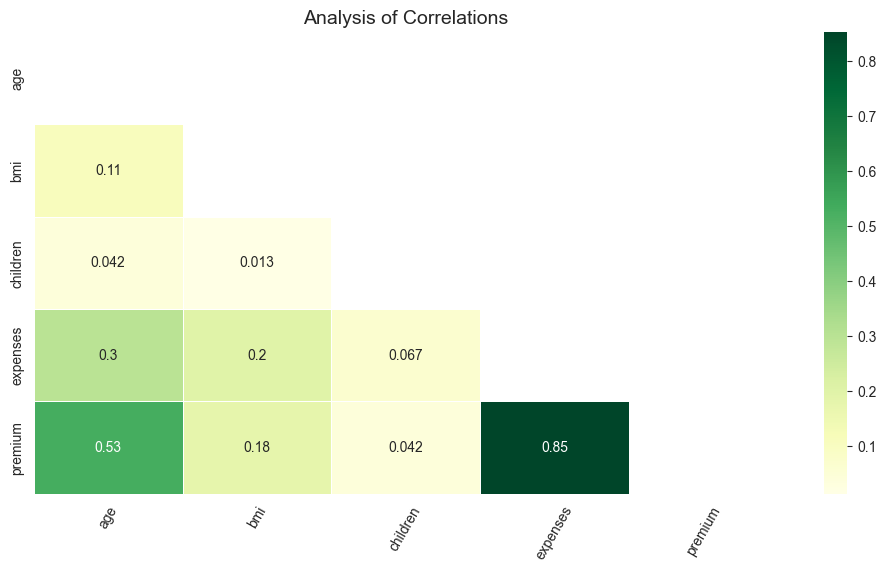

In [ ]:
def correlated_map(data, cmap="YlGn"):
    n_cols = len(data.columns.to_list())
    plt.figure(figsize=(n_cols * 1.5, n_cols * 0.75))
    sns.set_style("white")
    sns.heatmap(
        data.corr(numeric_only=True),
        cmap=cmap,
        annot=True,
        mask=np.triu(data.corr(numeric_only=True)),
        linewidths=0.6,
    )
    plt.title("Analysis of Correlations", size=14)
    plt.xticks(rotation=60, size=10)
    warnings.filterwarnings("ignore")

correlated_map(df)

Numerical_cols : ['age', 'bmi', 'expenses', 'premium'] 
 categorical_cols : ['gender', 'discount_eligibility', 'region', 'children'] 
 cardinal_cols : [] 
  Numerical_categorical : ['children']


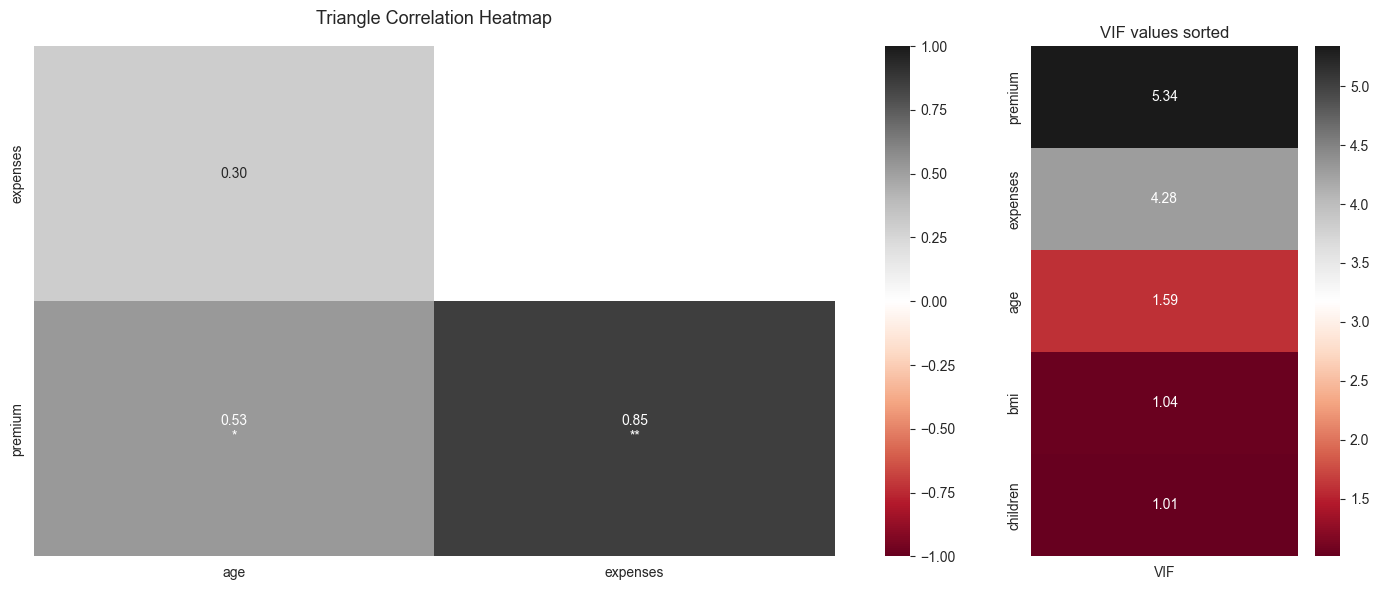

In [ ]:
Numerical_cols, categorical_cols, cardinal_cols, Numerical_categorical = grab_col_names(
    df
)


def triangle_correlation(data):
    corr = data.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    mask |= np.abs(corr) < 0.25
    corr = corr[~mask]
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
    annot = [
        [
            f"{val:.2f}"
            + ("" if abs(val) < 0.5 else "\n*")
            + ("" if abs(val) < 0.75 else "*")
            + ("" if abs(val) < 0.9 else "*")
            for val in row
        ]
        for row in corr.to_numpy()
    ]

    X = add_constant(data.select_dtypes(include=["int64", "float64"]))
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X.columns
    vif_df["VIF"] = [
        variance_inflation_factor(X.values, i).round(2) for i in range(X.shape[1])
    ]
    vif_df.sort_values(by="VIF", ascending=False, inplace=True)
    vif_df = vif_df.drop(0)

    f, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [3, 1]})
    heatmap = sns.heatmap(
        corr, vmin=-1, vmax=1, annot=annot, fmt="", cmap="RdGy", ax=axes[0]
    )
    heatmap.set_title("Triangle Correlation Heatmap", fontdict={"fontsize": 13}, pad=16)

    sns.heatmap(
        vif_df[["VIF"]],
        annot=True,
        cmap="RdGy",
        cbar=True,
        yticklabels=vif_df["Feature"],
        fmt=".2f",
        ax=axes[1],
    )
    axes[1].set_title("VIF values sorted")

    plt.grid()
    plt.tight_layout()
    plt.show()


triangle_correlation(df)

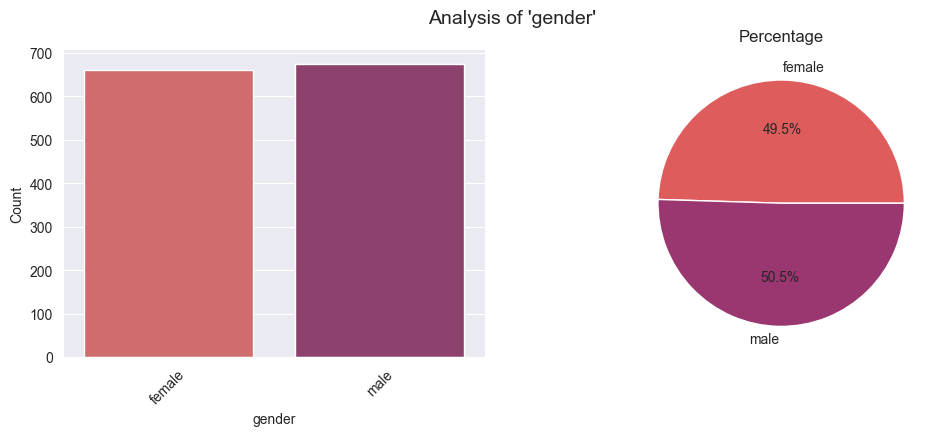

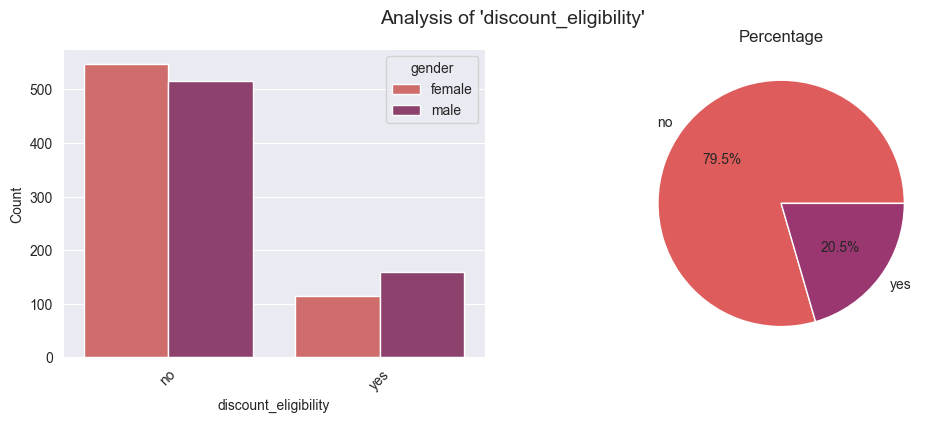

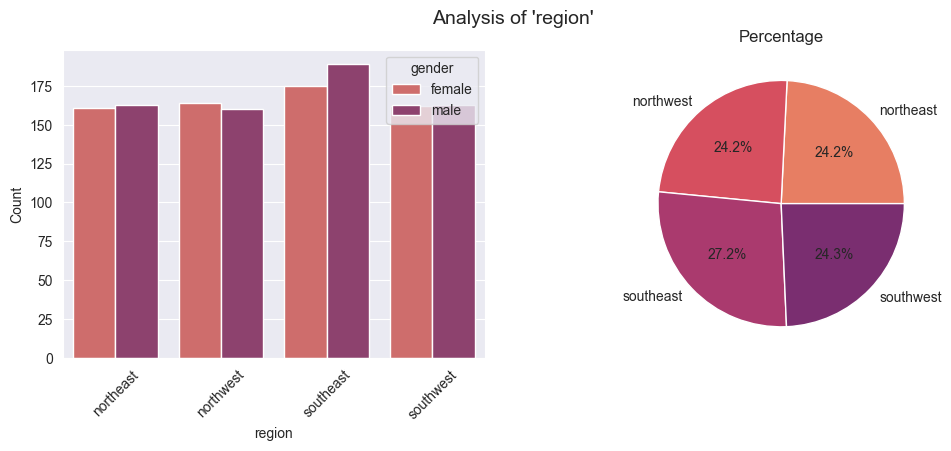

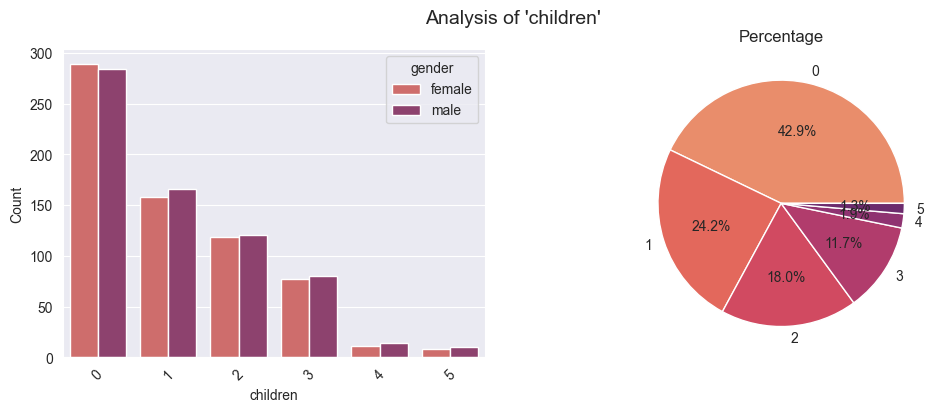

In [ ]:
def categorical_summary(df, columns: list | str, target_feature: str = None):
    if isinstance(columns, str):
        columns = [columns]

    for column in columns:
        sns.set_style("darkgrid")
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        value_counts_sorted = df[column].value_counts().sort_index()
        category_order = value_counts_sorted.index
        colors = sns.color_palette("flare", len(category_order))

        if target_feature:
            sns.countplot(
                data=df,
                x=column,
                ax=axes[0],
                hue=target_feature,
                palette="flare",
                order=category_order,
            )
        else:
            sns.countplot(
                data=df, x=column, ax=axes[0], palette="flare", order=category_order
            )

        axes[0].set_ylabel("Count")
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

        axes[1].pie(
            x=value_counts_sorted.values,
            labels=category_order,
            colors=colors,
            autopct="%1.1f%%",
        )
        axes[1].set_title("Percentage")

        fig.suptitle(f"Analysis of '{column}'", fontsize=14)
        warnings.filterwarnings("ignore")
        plt.show()


categorical_summary(df, columns=categorical_cols, target_feature="gender")

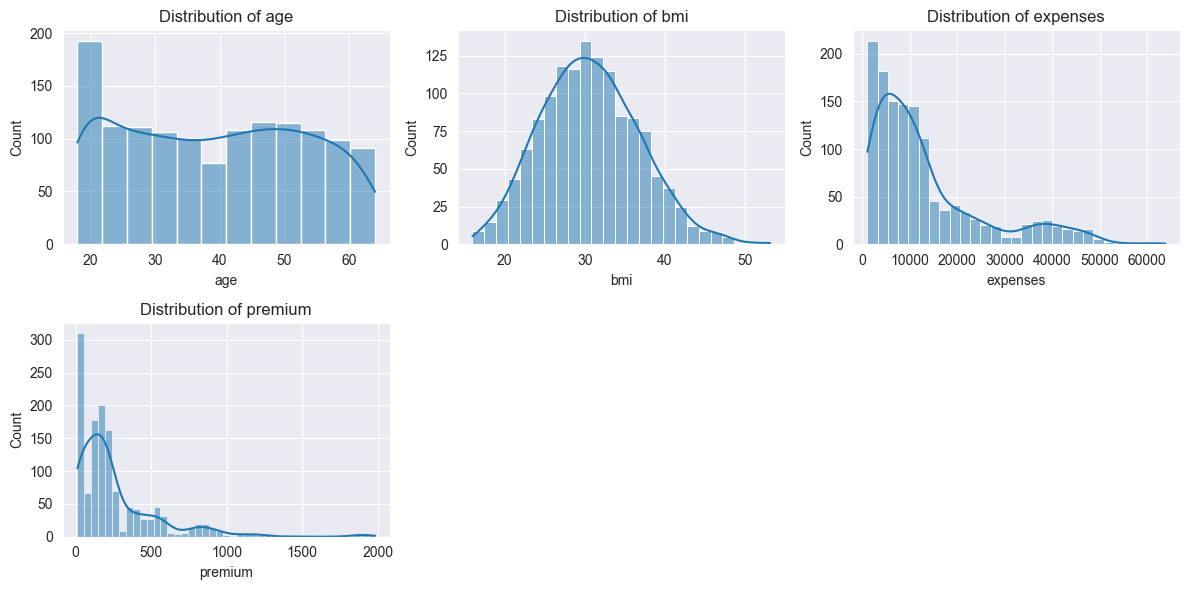

In [ ]:
def plot_hist_kde(df, columns: list, exclude=None, multiple: str = "layer", hue=None):
    columns = [col for col in columns if col != exclude]

    n_cols = 3
    num_plots = len(columns)
    n_rows = math.ceil(num_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    if isinstance(hue, str):
        for i, col in enumerate(columns):
            sns.histplot(
                data=df,
                x=col,
                kde=True,
                ax=axes[i],
                multiple=multiple,
                hue=hue,
                palette=sns.color_palette("tab20"),
            )
            axes[i].set_title(f"Distribution of {col}")
    else:
        for i, col in enumerate(columns):
            sns.histplot(
                x=df[col],
                kde=True,
                ax=axes[i],
                multiple=multiple,
                palette=sns.color_palette("tab20"),
            )
            axes[i].set_title(f"Distribution of {col}")

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_hist_kde(df, Numerical_cols)

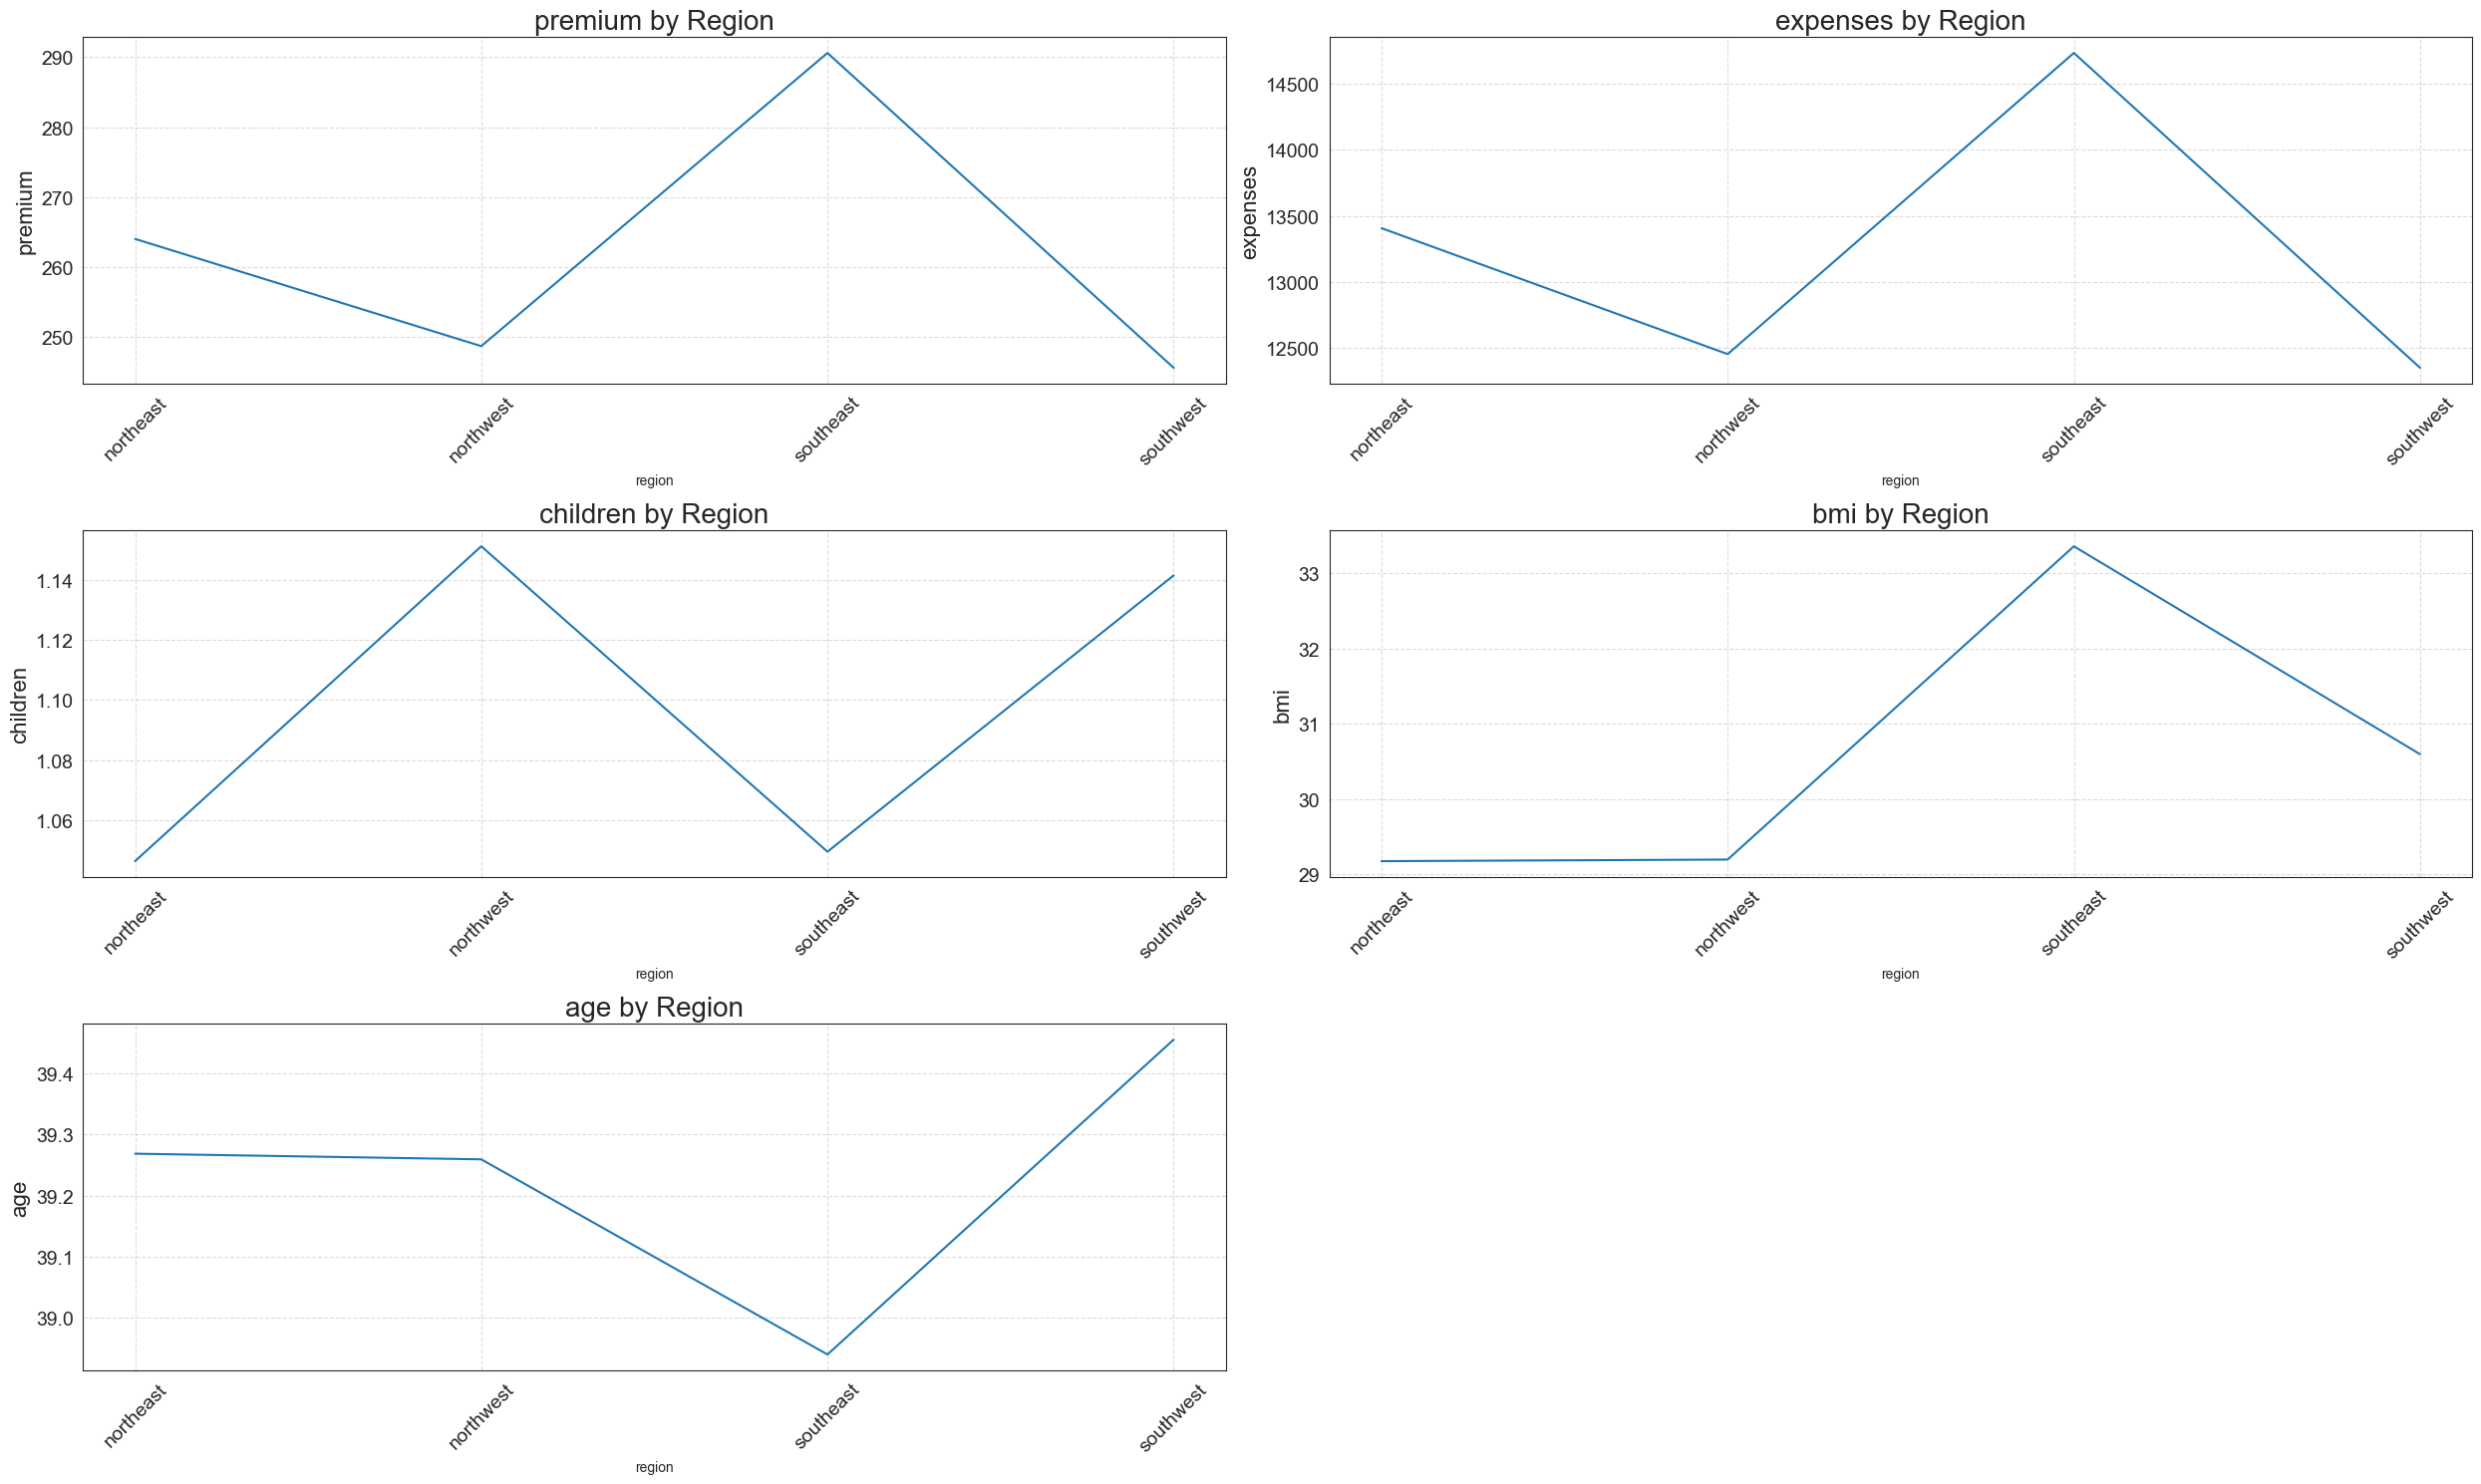

In [14]:
df_group = df.groupby('region')[['premium','expenses','children','bmi','age']].mean()

sns.set_style('white')
fig,axes = plt.subplots(3,2,figsize=(25,15))
for i , column in enumerate(df_group.columns.to_list()):
    row,col = divmod(i,2)
    sns.lineplot(data=df_group,x=df_group.index , y=column,ax=axes[row,col])
    axes[row, col].set_title(f'{column} by Region', fontsize=20)
    axes[row, col].set_ylabel(column, fontsize=16)
    axes[row, col].tick_params(axis='x', rotation=45, labelsize=14)
    axes[row, col].tick_params(axis='y', labelsize=14)
    axes[row, col].grid(True, linestyle='--', alpha=0.7)

axes = axes.flatten()
for j in range(i+1,len(axes)):
    row,col = divmod(j,2)
    fig.delaxes(ax=axes[j])

plt.tight_layout()
plt.show()

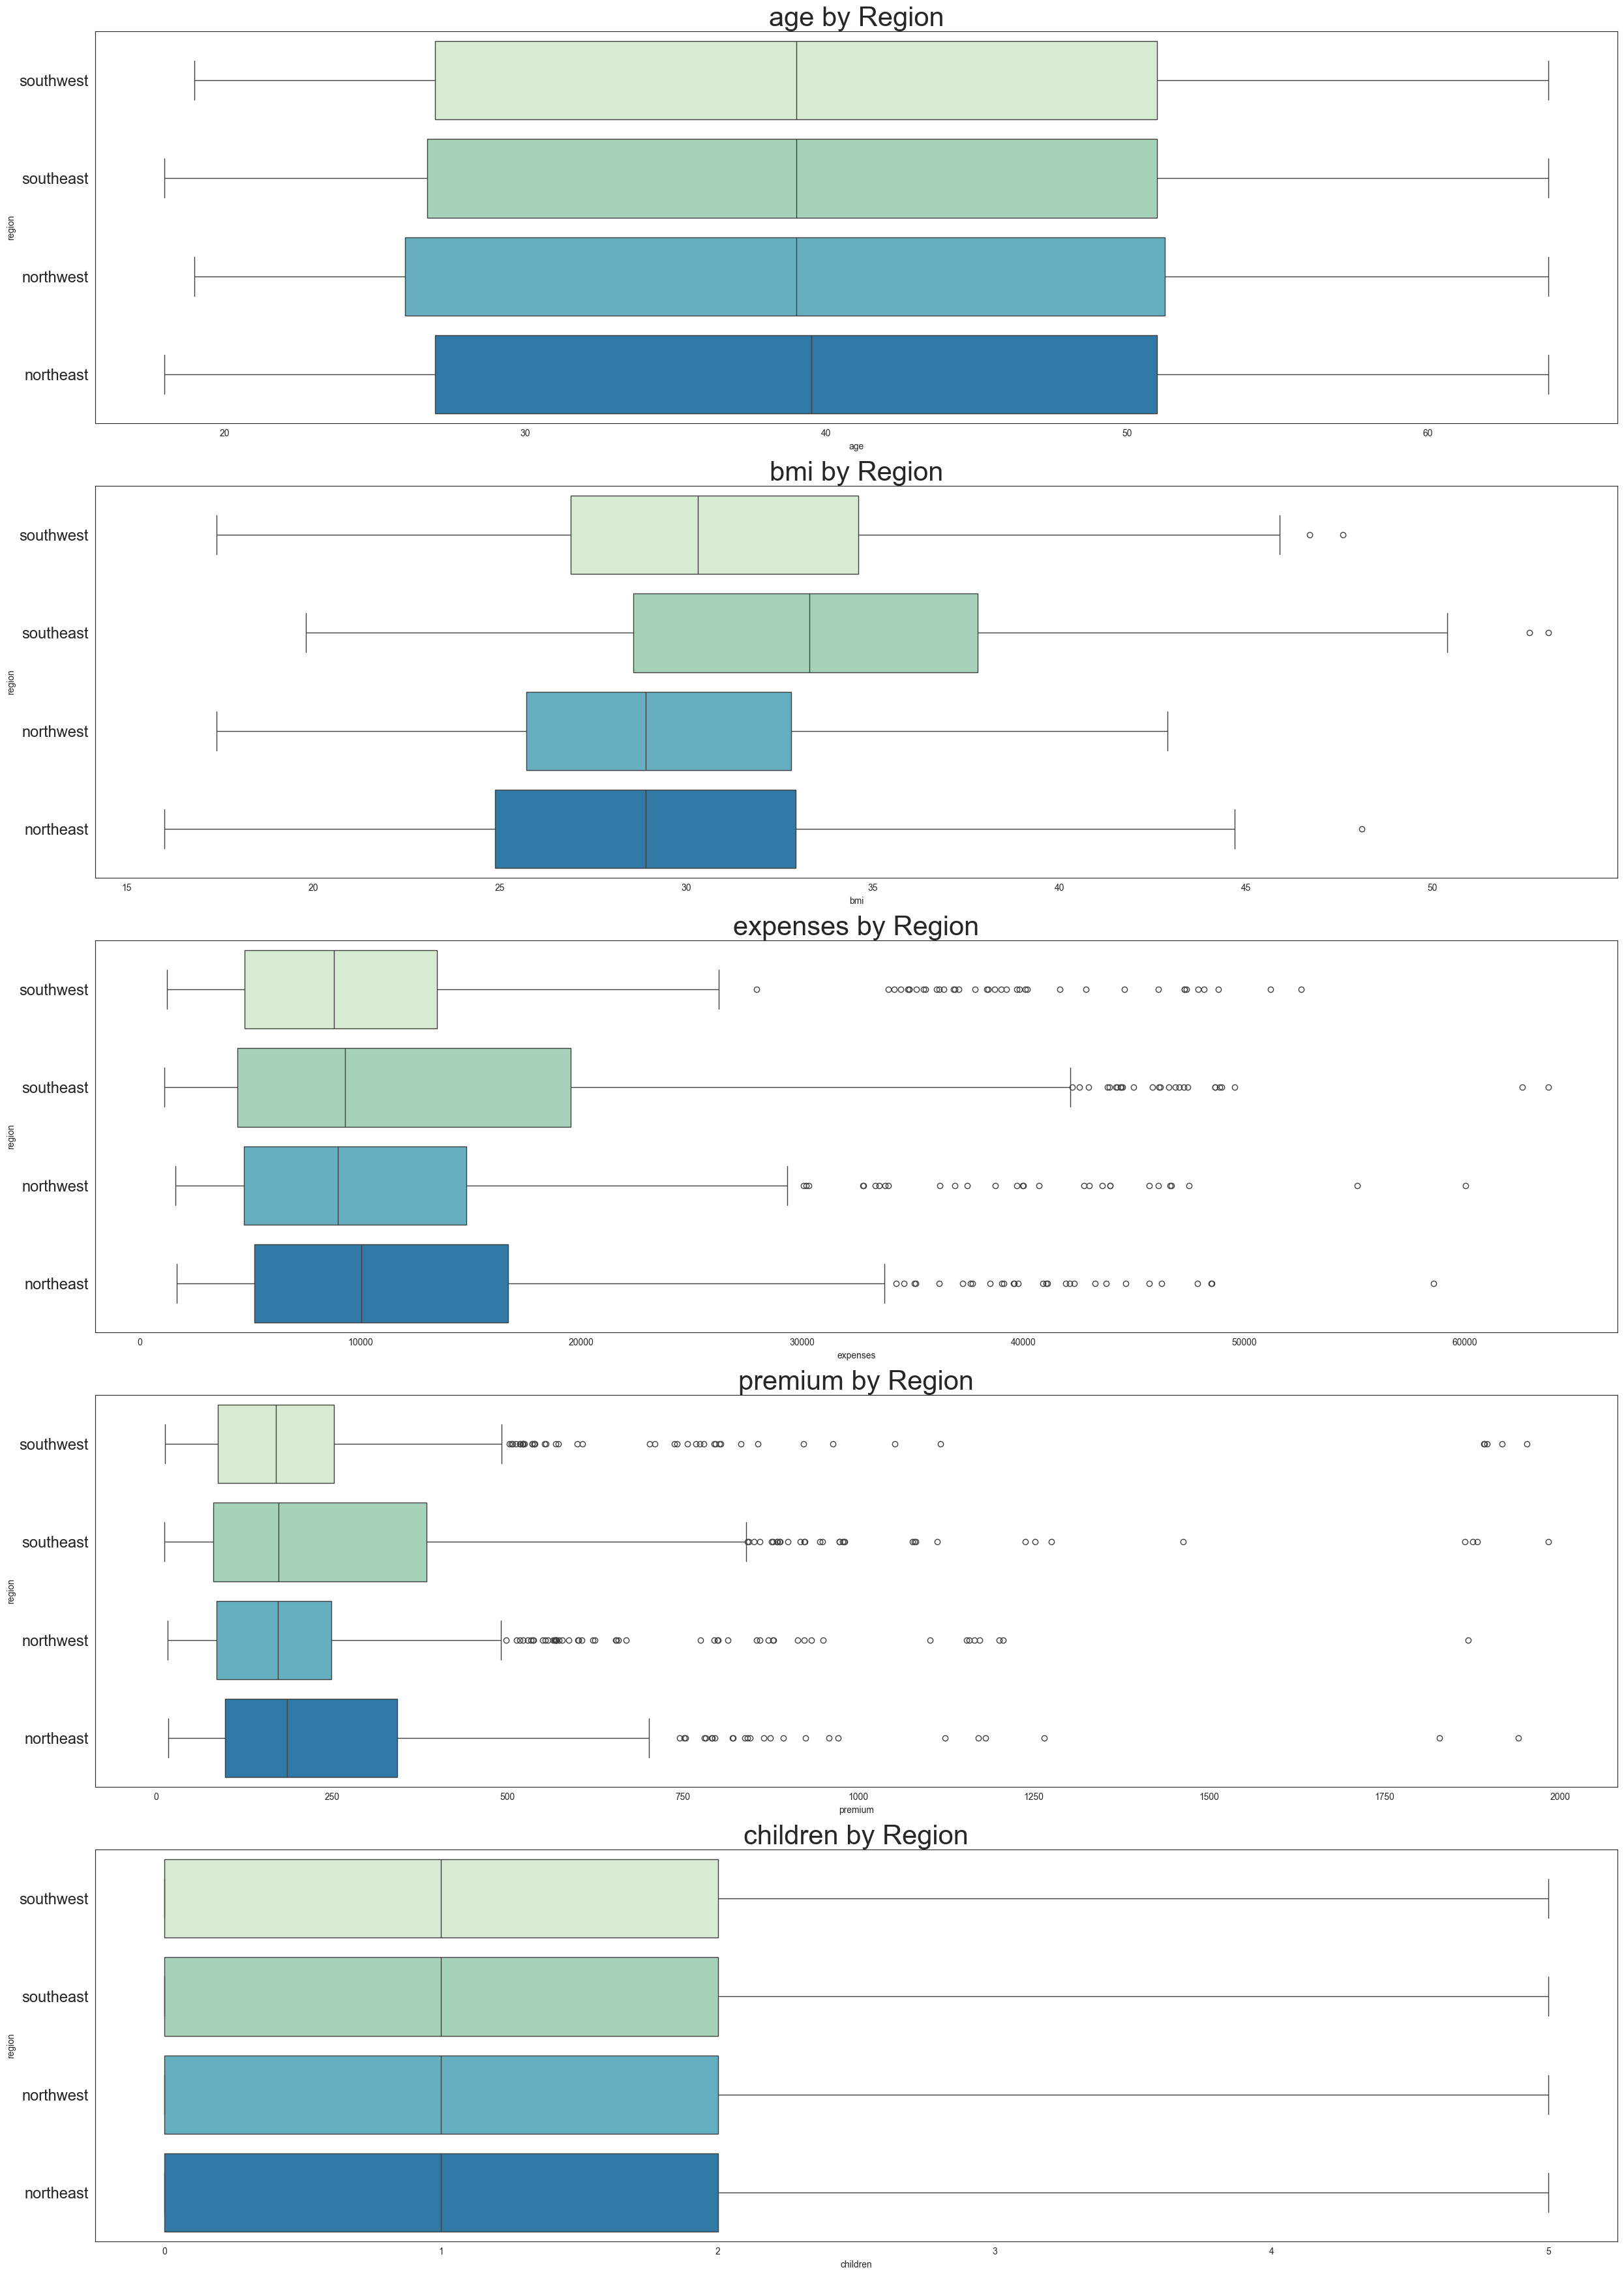

In [15]:
num_cols = Numerical_cols + Numerical_categorical

fig,axes = plt.subplots(5,1,figsize=(25,35))
for i, column in enumerate(num_cols):
    sns.boxplot(data=df,x=column,y='region',palette='GnBu',ax=axes[i])
    axes[i].set_title(f'{column} by Region', fontsize=30)
    axes[i].tick_params(axis='y', labelsize=17)

plt.tight_layout()
plt.show()

In [ ]:
def outlier_counter(data, min_out):
    """
    Outliers Conuter By 3*STD method
    """
    outliers = []
    for col in data.columns:
        mean = data[col].mean()
        std = data[col].std()
        cut_off = 3 * std
        col_values = data[col]
        mask = (col_values > mean + cut_off) | (col_values < mean - cut_off)
        outlier_idx = data.index[mask]
        outliers.extend(outlier_idx)
        print(f"{col} : {len(outlier_idx)} outliers")

    outlier_counts = Counter(outliers)
    OUTs = [idx for idx, count in outlier_counts.items() if count >= min_out]
    print("\nTotal number of outliers is:", len(OUTs))

    return sorted(OUTs)

outs = outlier_counter(df[num_cols],1)

age : 0 outliers
bmi : 4 outliers
expenses : 7 outliers
premium : 25 outliers
children : 18 outliers

Total number of outliers is: 50


In [ ]:
def outlier_counter_iqr(data, min_out, Q1=0.25, Q3=0.75):
    """
    Outliers Conuter By IQR method and Return Outliers Indexes
    """
    outliers = []
    for col in data.columns:
        Q1_val = data[col].quantile(Q1)
        Q3_val = data[col].quantile(Q3)
        IQR = Q3_val - Q1_val
        lower_bound = Q1_val - 1.5 * IQR
        upper_bound = Q3_val + 1.5 * IQR

        mask = (data[col] < lower_bound) | (data[col] > upper_bound)
        outlier_idx = data.index[mask]
        outliers.extend(outlier_idx)
        print(f"{col} : {len(outlier_idx)} outliers")

    from collections import Counter

    outlier_counts = Counter(outliers)
    OUTs = [idx for idx, count in outlier_counts.items() if count >= min_out]
    print("\nTotal number of outliers is:", len(OUTs))

    return OUTs


outs_iqr = outlier_counter_iqr(df[num_cols], 1)

intersection = [x for x in outs if x in outs_iqr]
print(len(intersection))

age : 0 outliers
bmi : 9 outliers
expenses : 139 outliers
premium : 113 outliers
children : 0 outliers

Total number of outliers is: 160
32


In [ ]:
df2 = df.drop(intersection,axis=0).reset_index(drop=True)

In [19]:
gender_dum = pd.get_dummies(df2["gender"], drop_first=True)
eligibility_dum = pd.get_dummies(df2["discount_eligibility"], drop_first=True)
region_dum = pd.get_dummies(df2["region"], drop_first=False)

df3 = pd.concat([df2.iloc[:, :-1], region_dum, df2.iloc[:, -1]], axis=1)
df3.drop(columns=["region"], inplace=True)
df3["gender"] = gender_dum
df3["discount_eligibility"] = eligibility_dum

df3

,age,gender,bmi,children,discount_eligibility,expenses,northeast,northwest,southeast,southwest,premium
0,19,False,27.90,0,True,16884.92,False,False,False,True,168.85
1,18,True,33.80,1,False,1725.55,False,False,True,False,17.26
2,28,True,33.00,3,False,4449.46,False,False,True,False,44.49
3,33,True,22.70,0,False,21984.47,False,True,False,False,439.69
4,32,True,28.90,0,False,3866.86,False,True,False,False,77.34
...,...,...,...,...,...,...,...,...,...,...,...
1300,52,False,44.70,3,False,11411.69,False,False,False,True,228.23
1301,50,True,31.00,3,False,10600.55,False,True,False,False,212.01
1302,18,False,31.90,0,False,2205.98,True,False,False,False,22.06
1303,18,False,36.90,0,False,1629.83,False,False,True,False,16.30


<a id="2"></a>

<h1 style="
    background-color:#488286; 
    background-size: cover;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    Modeling
</h1>

In [ ]:
def Regression_Model_Fitter(
    model_names: Union[str, list],
    model_objs: Union[object, list],
    df: pd.DataFrame,
    target_feature: str,
    models_reports: dict,
    cv: int = 5,
    test_size=0.2,
    degree=2,
    use_poly=False,
    standardScale=False,
):

    if len(model_names) != len(model_objs):
        raise ValueError("The length of 'model_names' is not Equal with 'model_objs'")
    if isinstance(model_names, str):
        model_names = [model_names]
    if not isinstance(model_objs, list):
        model_objs = [model_objs]

    x = df.drop(columns=target_feature)
    y = df[target_feature]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=0
    )

    if standardScale:
        st = StandardScaler()
        x_train = st.fit_transform(x_train)
        x_test = st.transform(x_test)

    if use_poly:
        poly = PolynomialFeatures(degree=degree, include_bias=True)
        x_train = poly.fit_transform(x_train)
        x_test = poly.transform(x_test)
        n_features = x_train.shape[1]
    else:
        n_features = x.shape[1]

    def adjusted_r2(r2, n_samples, n_features):
        return 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

    for model_name, model in zip(model_names, model_objs):
        models_reports.setdefault(model_name, {})
        model.fit(x_train, y_train)
        models_reports[model_name]["Model_obj"] = model
        models_reports[model_name]["y_test"] = y_test

        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        models_reports[model_name]["MAE_train"] = mean_absolute_error(
            y_train, y_pred_train
        )
        models_reports[model_name]["MAE_test"] = mean_absolute_error(
            y_test, y_pred_test
        )
        models_reports[model_name]["y_pred_test"] = y_pred_test
        models_reports[model_name]["R2_train"] = r2_score(y_train, y_pred_train)
        models_reports[model_name]["R2_test"] = r2_score(y_test, y_pred_test)
        models_reports[model_name]["R2_adj_train"] = adjusted_r2(
            models_reports[model_name]["R2_train"], len(y_train), n_features
        )
        models_reports[model_name]["R2_adj_test"] = adjusted_r2(
            models_reports[model_name]["R2_test"], len(y_test), n_features
        )

        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        cross_val = cross_val_score(model, x_train, y_train, cv=kf, scoring="r2")
        models_reports[model_name]["CV"] = round(np.mean(cross_val), 4)

    # R2 Comparitive PLOTS
    df_report = (
        pd.DataFrame(models_reports).T.reset_index().rename(columns={"index": "Model"})
    )
    df_long = pd.melt(
        df_report,
        id_vars="Model",
        value_vars=["R2_train", "R2_test"],
        var_name="Dataset",
        value_name="R2_Score",
    )
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_long, x="Model", y="R2_Score", hue="Dataset", marker="o")
    plt.xticks(rotation=45)
    plt.title("R2 Score Comparison: Train vs Test")
    plt.ylabel("R2 Score")
    plt.xlabel("Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # R2 Single PLOTS
    n_models = len(model_names)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 3))
    if n_models == 1:
        axes = [axes]
    axes = np.array(axes).flatten()
    for i, model_name in enumerate(model_names):
        sns.regplot(
            x=models_reports[model_name]["y_test"],
            y=models_reports[model_name]["y_pred_test"],
            color="#C65458",
            scatter_kws={"color": "#4C72B0"},
            label=f'R2: {models_reports[model_name]["R2_test"]:.2f}',
            ax=axes[i],
            ci=None,
        )
        axes[i].set_title(model_name)
        axes[i].legend()
        if i % 3 == 1:
            axes[i].set_yticks([])
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

    filtered_reports = {
        model: {
            k: v
            for k, v in report.items()
            if k not in ["Model_obj", "y_test", "y_pred_test"]
        }
        for model, report in models_reports.items()
    }
    df_results = pd.DataFrame(filtered_reports).T
    df_results = df_results.sort_values(by="R2_test", ascending=False)
    df_results = df_results.style.background_gradient(cmap="YlGn", axis=0).format(
        precision=3
    )

    return df_results

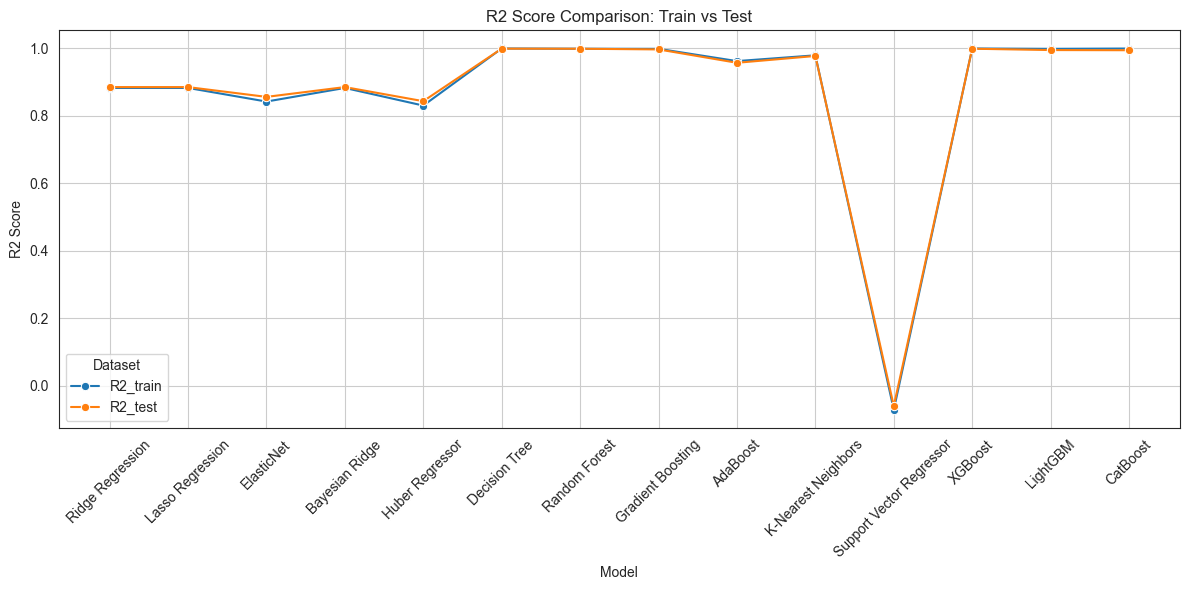

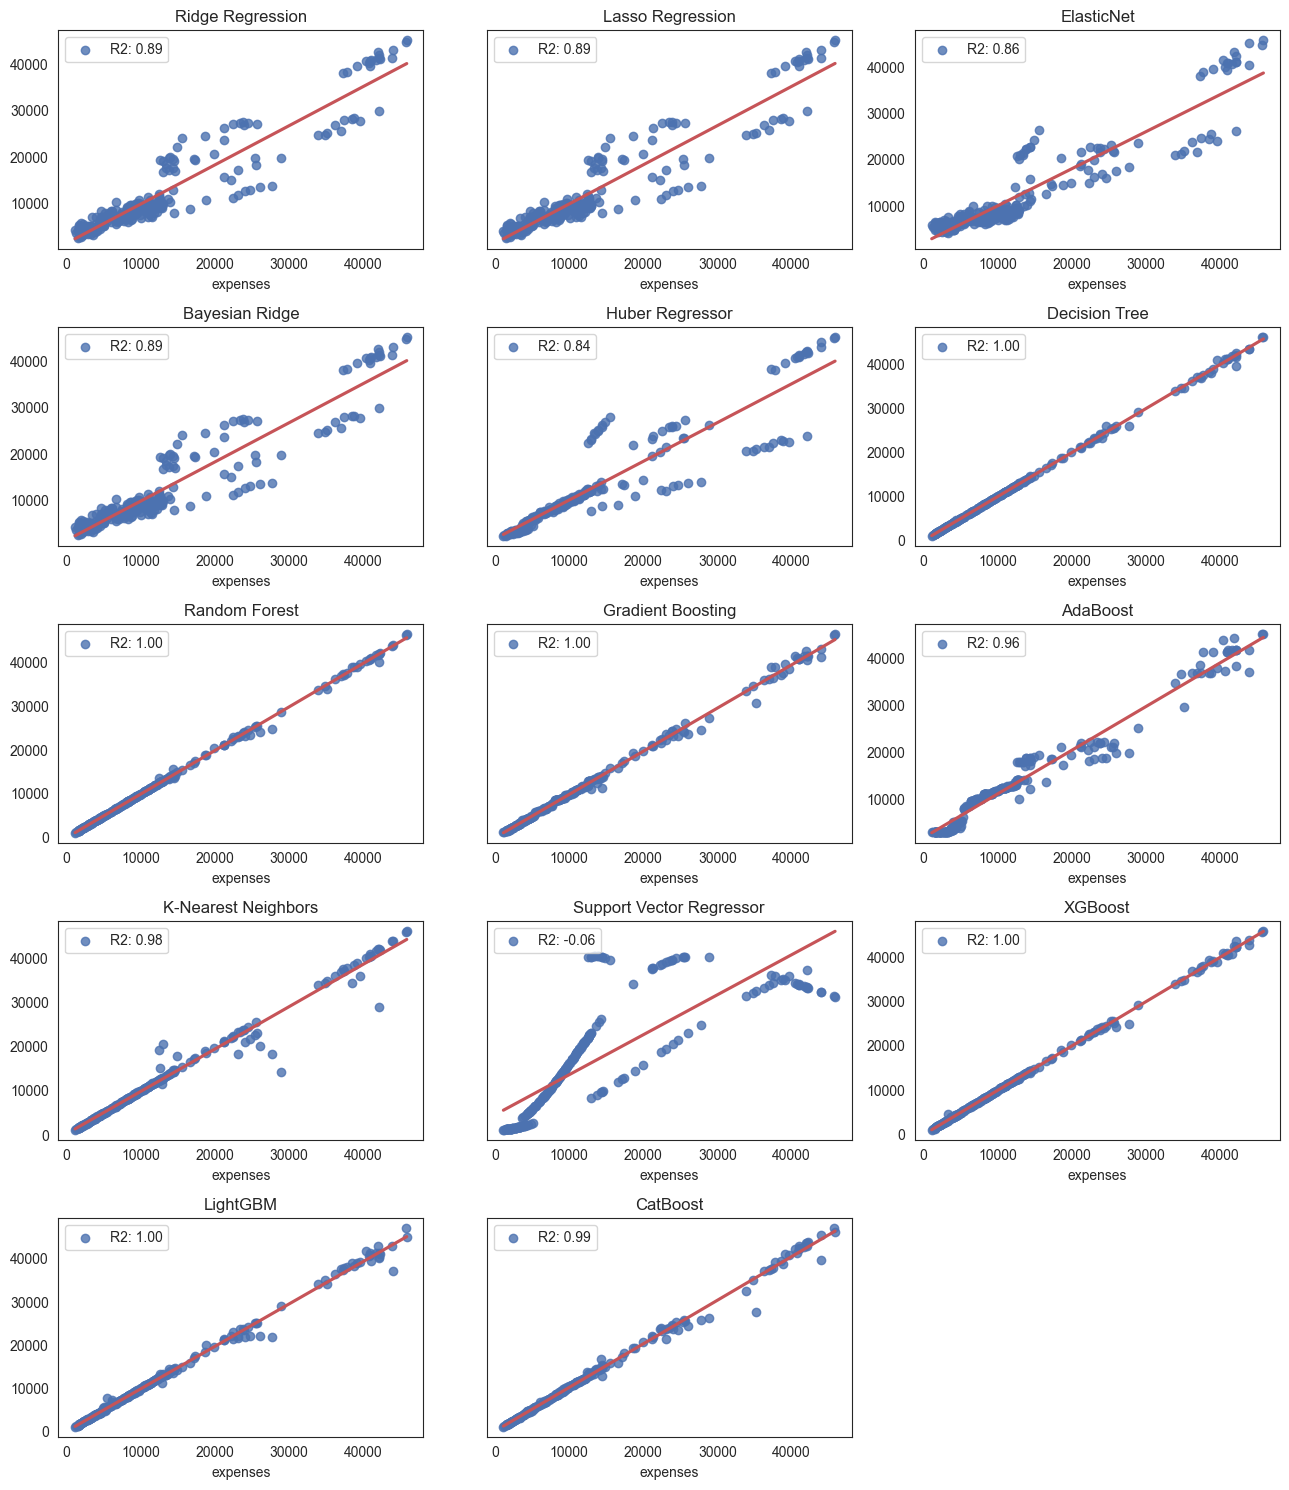

,MAE_train,MAE_test,R2_train,R2_test,R2_adj_train,R2_adj_test,CV
Decision Tree,0.00,82.18,1.00,1.00,1.00,1.00,0.99
XGBoost,12.48,123.04,1.00,1.00,1.00,1.00,1.00
Random Forest,57.03,96.26,1.00,1.00,1.00,1.00,0.99
Gradient Boosting,214.53,299.63,1.00,1.00,1.00,1.00,1.00
LightGBM,159.54,286.91,1.00,1.00,1.00,1.00,0.99
CatBoost,102.25,283.62,1.00,0.99,1.00,0.99,1.00
K-Nearest Neighbors,378.28,406.55,0.98,0.98,0.98,0.98,0.96
AdaBoost,1804.93,1819.99,0.96,0.96,0.96,0.96,0.96
Bayesian Ridge,2687.51,2545.84,0.88,0.89,0.88,0.88,0.88
Ridge Regression,2687.50,2544.93,0.88,0.89,0.88,0.88,0.88


In [ ]:
model_candidates = {
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet": ElasticNet(),
    "Bayesian Ridge": BayesianRidge(),
    "Huber Regressor": HuberRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
    "XGBoost": XGBRegressor(verbosity=0),
    "LightGBM": LGBMRegressor(verbose=-1),
    "CatBoost": CatBoostRegressor(verbose=0),
}

model_reports = {}
Regression_Model_Fitter(
    model_names=list(model_candidates.keys()),
    model_objs=list(model_candidates.values()),
    df=df3,
    target_feature="expenses",
    cv=5,
    models_reports=model_reports,
)

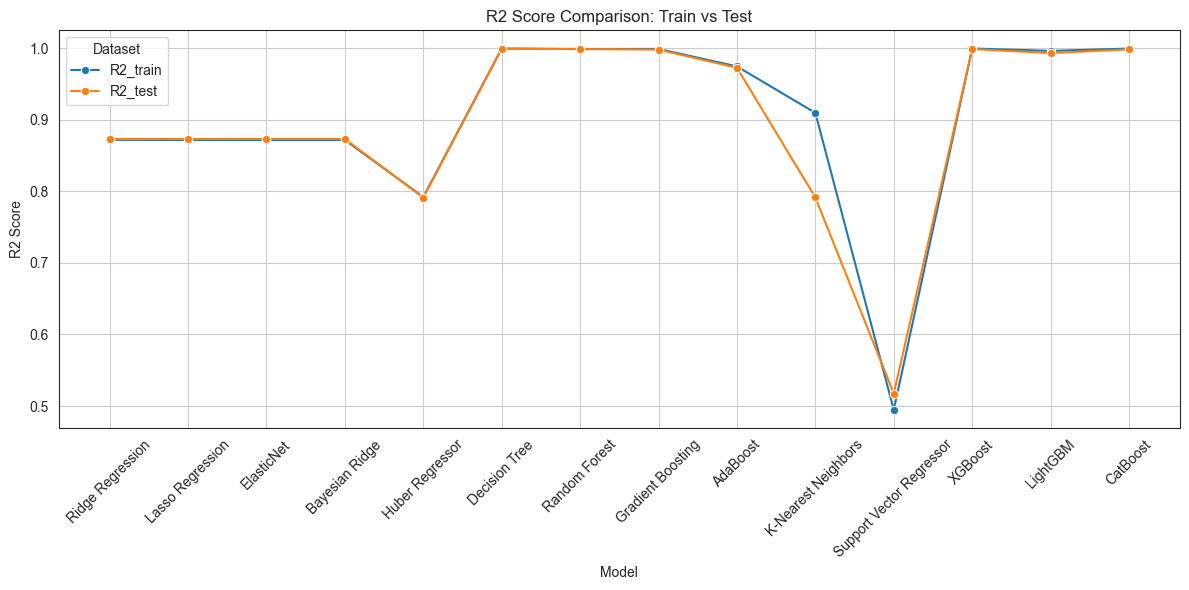

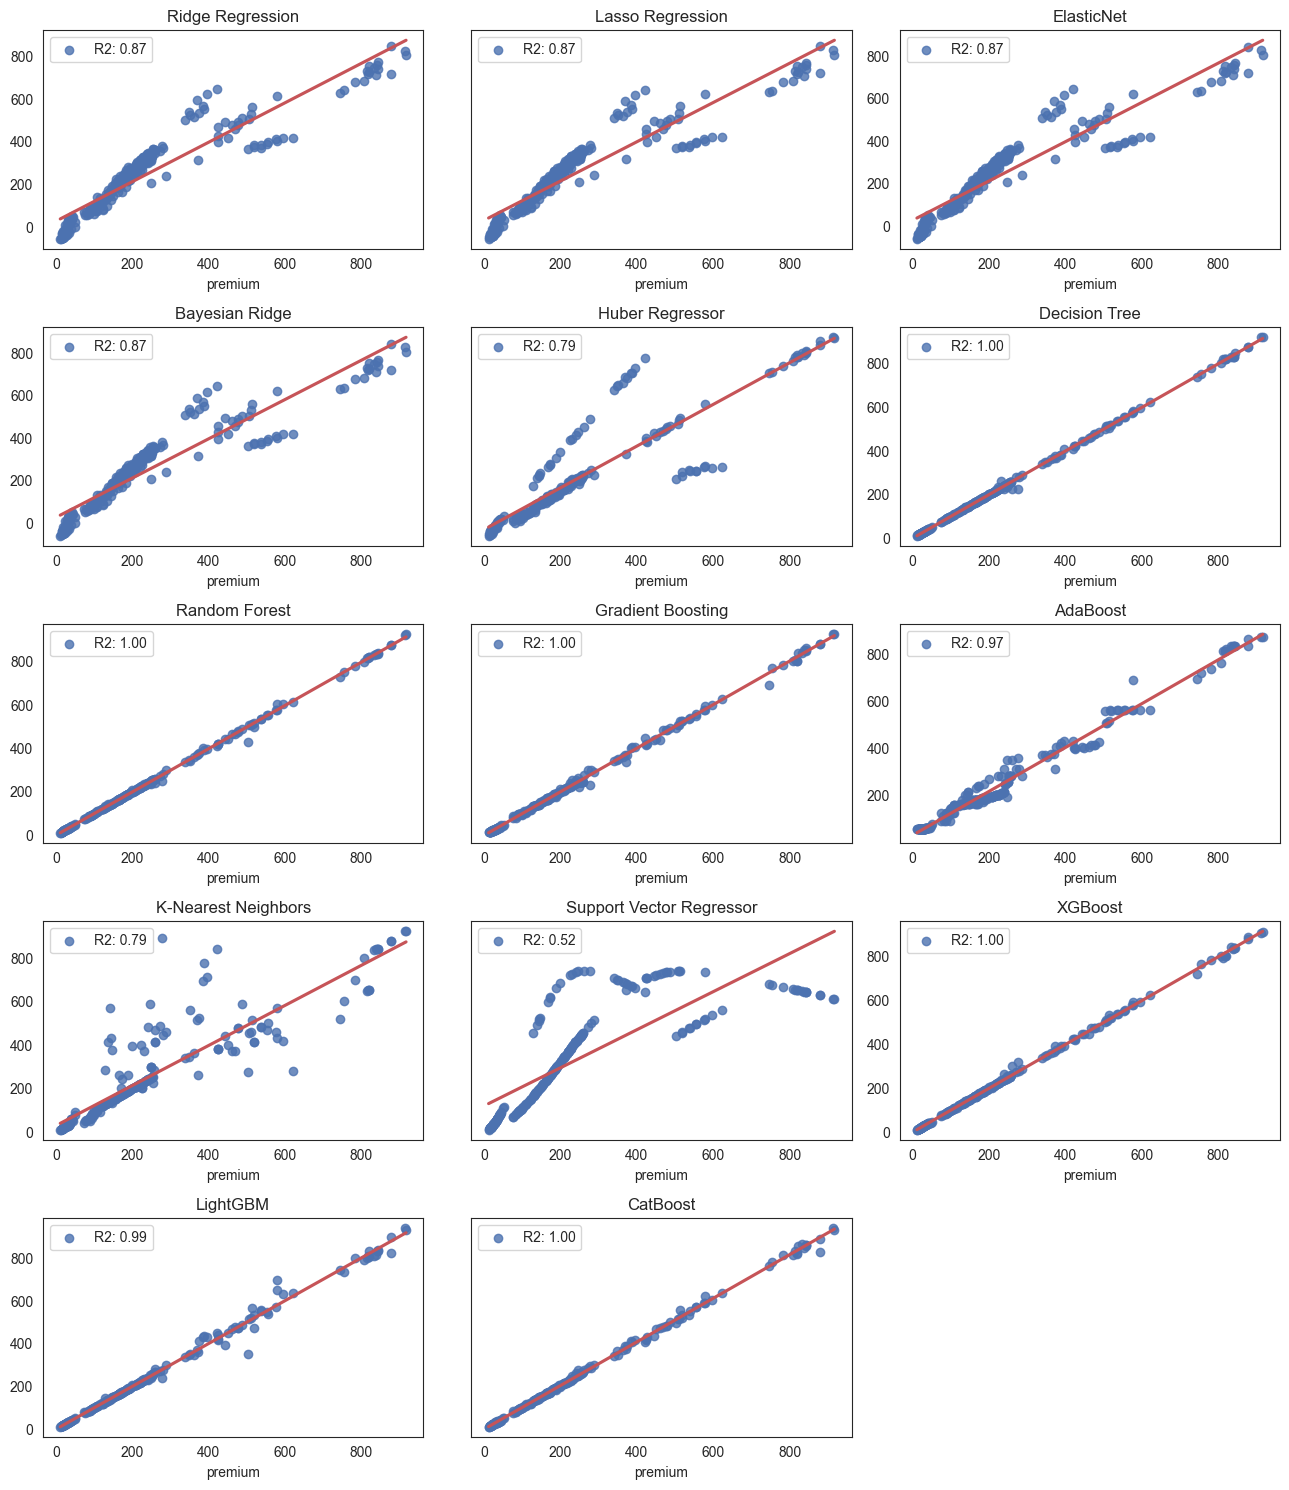

,MAE_train,MAE_test,R2_train,R2_test,R2_adj_train,R2_adj_test,CV
Decision Tree,0.00,1.58,1.00,1.00,1.00,1.00,1.00
Random Forest,1.15,1.74,1.00,1.00,1.00,1.00,1.00
XGBoost,0.24,2.60,1.00,1.00,1.00,1.00,0.99
CatBoost,1.62,3.79,1.00,1.00,1.00,1.00,0.99
Gradient Boosting,3.60,4.87,1.00,1.00,1.00,1.00,1.00
LightGBM,4.82,6.13,1.00,0.99,1.00,0.99,0.99
AdaBoost,31.26,28.96,0.97,0.97,0.97,0.97,0.97
Bayesian Ridge,59.10,58.70,0.87,0.87,0.87,0.87,0.87
ElasticNet,59.13,58.75,0.87,0.87,0.87,0.87,0.87
Ridge Regression,59.23,58.75,0.87,0.87,0.87,0.87,0.87


In [ ]:
# Set target_feature : premium

model_reports2 = {}
Regression_Model_Fitter(
    model_names=list(model_candidates.keys()),
    model_objs=list(model_candidates.values()),
    df=df3,
    target_feature="premium",
    cv=5,
    models_reports=model_reports2,
)